In [51]:
'''
For QFT, SPM, ADD, QAOA:
Do circuit sizes in Table 1 of paper
If possible, push for larger
Collect: 
# subcircuits
# wire cuts
# gate cuts
depth of pre-cut circuit
depth of subcircuits
time to find optimal solution
time to reconstruct in postprocessing step
Error
Relative error
'''

from qiskit.circuit import QuantumCircuit
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import execute_simulation
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_expectation_values
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import exact_observables
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import compare_results
import time

def benchmark(circuit: QuantumCircuit, observables: list[str], get_errors=False):
    # Cut the circuits
    opt_s = time.time()
    subcircuits, subobservables, wire_cuts, gate_cuts = cut_wires_and_gates_to_subcircuits(
        circuit=circuit,
        observables=observables,
        method='automatic',
        max_subcircuit_width=2,
        max_cuts=4,
        num_subcircuits=[2],
        model='gurobi'
    )
    opt_time = time.time() - opt_s
    
    # Execute the subcircuits
    recon_s = time.time()
    quasi_dists, coefficients = execute_simulation(subcircuits, subobservables)
    simulation_expvals = reconstruct_expectation_values(quasi_dists, coefficients, subobservables)
    recon_time = time.time() - recon_s
    
    ideal_expvals = exact_observables(circuit, observables)
    
    errors, rel_errors = compare_results(simulation_expvals, ideal_expvals)
    
    return len(subcircuits), wire_cuts, gate_cuts, circuit.depth(), subcircuits, opt_time, recon_time, errors, rel_errors

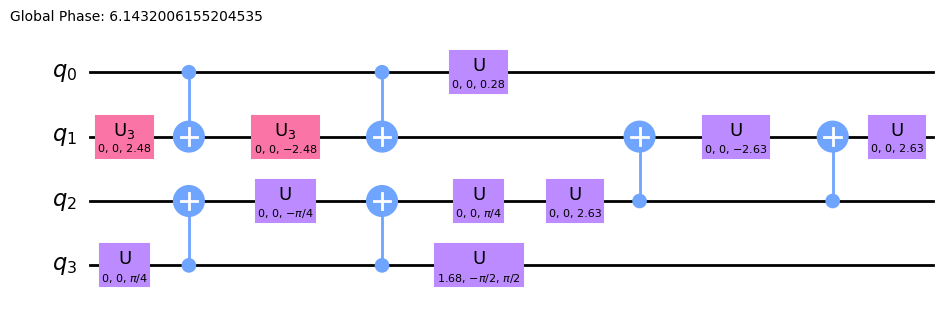

In [55]:
from qiskit.circuit.random import random_circuit
q = 4

circuit = random_circuit(q, 2, measure=False).decompose(reps=3)
circuit.draw('mpl')

In [56]:
n_subcircuits, wire_cuts, gate_cuts, circuit_depth, subcircuits, opt_time, recon_time, errors, rel_errors = benchmark(circuit, ['Z'*q])

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 157 rows, 75 columns and 502 nonzeros
Model fingerprint: 0x484759a1
Variable types: 0 continuous, 75 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 157 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.

In [57]:
print(n_subcircuits, wire_cuts, gate_cuts, circuit_depth)

print(subcircuits[0].depth(), opt_time, recon_time, errors, rel_errors)

2 0 2 10
8 0.033527374267578125 0.8490545749664307 [0.00276269] [-0.02626393]


In [58]:
[c.depth() for c in subcircuits.values()]

[8, 8]

In [59]:
print(f'''
Number of subcircuits: {n_subcircuits}
Number of wire cuts: {wire_cuts}
Number of gate cuts: {gate_cuts}
Original circuit depth: {circuit_depth}
Subcircuits' depths:  {[c.depth() for c in subcircuits.values()]}
Optimal solution time: {opt_time} seconds
Reconstruction time: {recon_time} seconds
Error: {errors}
Relative error: {rel_errors}''')


Number of subcircuits: 2
Number of wire cuts: 0
Number of gate cuts: 2
Original circuit depth: 10
Subcircuits' depths:  [8, 8]
Optimal solution time: 0.033527374267578125 seconds
Reconstruction time: 0.8490545749664307 seconds
Error: [0.00276269]
Relative error: [-0.02626393]
